# Adversarial Example Generation

Here, we use [PyTorch's Tutorial](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html) to generate Adversarial examples of the MNIST dataset. 

Since we want to test the adversarial robustness on cloud AutoAI models, whose model configurations do not match PyTorch configurations, we instead use LeNet to obtain adversarial examples. According to the Transferrability Property, examples that are adcersarial to one model would be adversarial to another model, so we use these examples to test the robustness of Cloud AutoAI models trained on the MNIST dataset.

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# NOTE: This is a hack to get around "User-agent" limitations when downloading MNIST datasets
#       see, https://github.com/pytorch/vision/issues/3497 for more information
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [8]:
'''
Input:
epsilons - List of epsilon values to use for the run. It is important to keep 0 in the list because it represents the model performance on the original test set. Also, intuitively we would expect the larger the epsilon, the more noticeable the perturbations but the more effective the attack in terms of degrading model accuracy. Since the data range here is [0,1][0,1], no epsilon value should exceed 1.
pretrained_model - path to the pretrained MNIST model which was trained with pytorch/examples/mnist. For simplicity, download the pretrained model from https://drive.google.com/drive/folders/1fn83DF14tWmit0RTKWRhPq5uVXt73e0h.

'''
epsilons = [0,.3, .15, .1, .25, .2]
pretrained_model = "lenet_mnist_model.pth"
use_cuda=True

## LeNet Model

In [4]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  True


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

## FGSM Attack

In [5]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [6]:
## Testing Function

def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            #if (epsilon == 0) and (len(adv_examples) < 5):
            if epsilon ==0:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            #if len(adv_examples) < 5:
            if True:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

## Running Atatck

In [9]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.3	Test Accuracy = 869 / 10000 = 0.0869
Epsilon: 0.15	Test Accuracy = 6826 / 10000 = 0.6826
Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.25	Test Accuracy = 2082 / 10000 = 0.2082
Epsilon: 0.2	Test Accuracy = 4301 / 10000 = 0.4301


## Sample Adversarial Examples

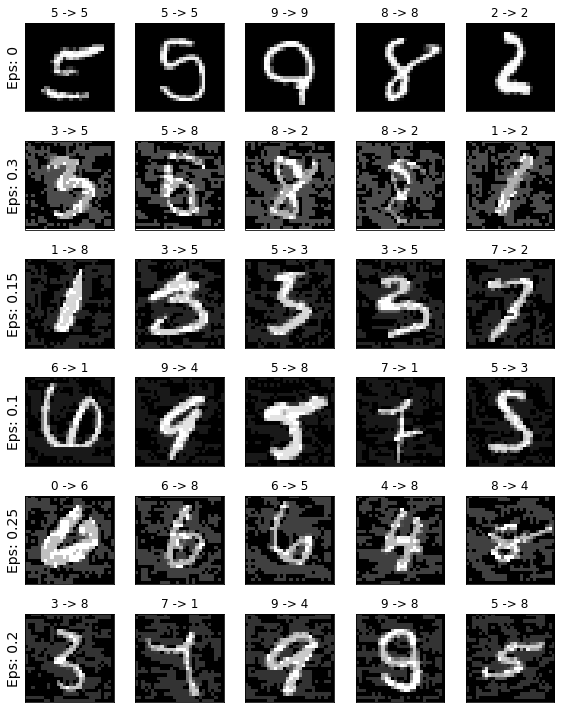

In [28]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(5):
    #for j in range(len(examples[i])):
        cnt += 1
        #plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.subplot(len(epsilons),5,cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

## Save Adversarial Examples

### Epsilon = 0.3

In [ ]:
true_labels = [x[0] for x in examples[1]]
adv_labels =  [x[1] for x in examples[1]]
adv_examples = [x[2].reshape(1,784)[0] for x in examples[1]]

In [ ]:
np.savetxt('adv_data.csv',adv_examples, delimiter=', ', fmt='%12.8f')
np.savetxt('adv_labels.csv',adv_labels, delimiter=', ')
np.savetxt('true_labels.csv',true_labels, delimiter=', ')

In [ ]:
data = pd.read_csv('adv_data.csv', header=None, index_col=None)
adv_labels = pd.read_csv('adv_labels.csv', header=None, index_col=None)
true_labels = pd.read_csv('true_labels.csv', header=None, index_col=None)

In [ ]:
adv_labels = adv_labels.astype(int)
true_labels = true_labels.astype(int)

In [ ]:
test = pd.concat([true_labels, adv_labels, data], ignore_index=True, axis=1)
test = test.rename(columns={0:'true_label'})
test = test.rename(columns={1:'adv_label'})
test.head()

,true_label,adv_label,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785
0,1,8,0.0,0.3,0.0,0.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.3,0.3,0.3,0.3,0.0,0.0,0.0,...,0.0,0.0,0.3,0.3,0.3,0.3,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.3,0.3,0.0,0.3,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,8,0.3,0.3,0.3,0.0,0.0,0.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.0,0.0,0.0,0.0,0.3,0.3,0.3,0.3,0.3,0.3,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.3,0.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.0,0.3,0.3,0.3,0.3,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0
2,3,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.3,0.0,0.3,0.3,0.3,0.3,0.3,0.3,0.0,0.3,0.3,0.3,0.3,0.3,0.3,0.0,0.0,0.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.0,0.0,...,0.0,0.0,0.0,0.0,0.3,0.3,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.0,0.3,0.3,0.0,0.3,0.0,0.0,0.0
3,1,8,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.0,0.3,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.3,0.0,...,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.3,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,7,0.3,0.3,0.3,0.0,0.3,0.0,0.3,0.0,0.3,0.3,0.3,0.3,0.3,0.0,0.3,0.3,0.3,0.0,0.3,0.3,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.3,0.0,0.3,0.0,0.3,0.3,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.3,0.3,0.3,0.3,0.0,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
test.to_csv('adv_examples_30.csv', sep=',', header=True, index=False)

### Episolon = 0.15

In [ ]:
true_labels = [x[0] for x in examples[2]]
adv_labels =  [x[1] for x in examples[2]]
adv_examples = [x[2].reshape(1,784)[0] for x in examples[2]]

In [ ]:
np.savetxt('adv_data.csv',adv_examples, delimiter=', ', fmt='%12.8f')
np.savetxt('adv_labels.csv',adv_labels, delimiter=', ')
np.savetxt('true_labels.csv',true_labels, delimiter=', ')

In [ ]:
data = pd.read_csv('adv_data.csv', header=None, index_col=None)
adv_labels = pd.read_csv('adv_labels.csv', header=None, index_col=None)
true_labels = pd.read_csv('true_labels.csv', header=None, index_col=None)

In [ ]:
adv_labels = adv_labels.astype(int)
true_labels = true_labels.astype(int)

In [ ]:
test = pd.concat([true_labels, adv_labels, data], ignore_index=True, axis=1)
test = test.rename(columns={0:'true_label'})
test = test.rename(columns={1:'adv_label'})
test.head()

,true_label,adv_label,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785
0,5,3,0.15,0.15,0.15,0.00,0.15,0.15,0.15,0.15,0.15,0.00,0.15,0.00,0.00,0.00,0.15,0.00,0.00,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.00,0.00,0.0,0.15,0.00,0.00,0.00,0.15,0.15,0.15,0.15,0.00,0.00,...,0.15,0.00,0.15,0.00,0.15,0.15,0.15,0.15,0.15,0.15,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.15,0.00,0.00,0.00,0.00,0.15,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.00,0.0,0.0
1,2,8,0.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.00,0.00,0.00,0.15,0.15,0.15,0.00,0.15,0.0,0.15,0.15,0.15,0.00,0.00,0.00,0.00,0.00,0.00,0.15,...,0.00,0.00,0.00,0.15,0.15,0.15,0.15,0.00,0.15,0.00,0.15,0.15,0.0,0.0,0.0,0.0,0.0,0.00,0.15,0.15,0.00,0.15,0.15,0.00,0.00,0.00,0.15,0.15,0.15,0.15,0.15,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.0,0.0
2,8,4,0.15,0.15,0.00,0.00,0.00,0.15,0.15,0.15,0.15,0.15,0.00,0.00,0.00,0.00,0.15,0.15,0.15,0.15,0.00,0.15,0.15,0.15,0.15,0.00,0.00,0.00,0.00,0.0,0.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.15,...,0.15,0.00,0.15,0.15,0.00,0.00,0.15,0.15,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.15,0.15,0.15,0.15,0.15,0.00,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
3,4,9,0.00,0.00,0.15,0.15,0.15,0.15,0.15,0.00,0.00,0.15,0.15,0.15,0.15,0.00,0.00,0.00,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.00,0.00,0.15,0.15,0.0,0.00,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,...,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.00,0.00,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.00,0.0,0.0
4,5,8,0.00,0.00,0.00,0.15,0.15,0.15,0.15,0.00,0.00,0.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.15,0.15,0.0,0.00,0.00,0.00,0.15,0.15,0.15,0.15,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.15,0.15,0.15,0.15,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.15,0.00,0.00,0.00,0.00,0.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0


In [ ]:
test.to_csv('adv_examples_15.csv', sep=',', header=True, index=False)

## Epsilon = 0.1

In [10]:
true_labels = [x[0] for x in examples[3]]
adv_labels =  [x[1] for x in examples[3]]
adv_examples = [x[2].reshape(1,784)[0] for x in examples[3]]

In [11]:
np.savetxt('adv_data.csv',adv_examples, delimiter=', ', fmt='%12.8f')
np.savetxt('adv_labels.csv',adv_labels, delimiter=', ')
np.savetxt('true_labels.csv',true_labels, delimiter=', ')

In [12]:
data = pd.read_csv('adv_data.csv', header=None, index_col=None)
adv_labels = pd.read_csv('adv_labels.csv', header=None, index_col=None)
true_labels = pd.read_csv('true_labels.csv', header=None, index_col=None)

In [13]:
adv_labels = adv_labels.astype(int)
true_labels = true_labels.astype(int)

In [14]:
test = pd.concat([true_labels, adv_labels, data], ignore_index=True, axis=1)
test = test.rename(columns={0:'true_label'})
test = test.rename(columns={1:'adv_label'})
test.head()

,true_label,adv_label,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785
0,6,1,0.0,0.0,0.0,0.1,0.1,0.1,0.1,0.1,0.0,0.1,0.0,0.0,0.1,0.0,0.1,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.1,0.1,0.1,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.1,0.0,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9,4,0.1,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.1,0.1,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.1,0.0,0.1,0.0,0.1,0.1,0.1,...,0.0,0.0,0.1,0.1,0.0,0.1,0.0,0.1,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,8,0.0,0.1,0.0,0.0,0.1,0.1,0.1,0.0,0.0,0.1,0.1,0.0,0.1,0.1,0.1,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.1,0.1,0.1,0.0,0.1,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.1,0.0,0.1,0.1,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.1,0.1,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7,1,0.0,0.1,0.1,0.1,0.1,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.0,0.1,0.1,0.1,0.0,0.1,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,3,0.0,0.0,0.0,0.1,0.1,0.1,0.1,0.1,0.1,0.0,0.1,0.0,0.1,0.0,0.1,0.0,0.0,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.0,0.1,0.1,0.0,0.0,0.1,0.1,0.1,0.1,0.0,0.1,...,0.0,0.0,0.1,0.0,0.0,0.1,0.1,0.1,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.0,0.0,0.0,0.1,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
test.to_csv('adv_examples_10.csv', sep=',', header=True, index=False)

## Epsilon = 0.25

In [16]:
true_labels = [x[0] for x in examples[4]]
adv_labels =  [x[1] for x in examples[4]]
adv_examples = [x[2].reshape(1,784)[0] for x in examples[4]]

In [17]:
np.savetxt('adv_data.csv',adv_examples, delimiter=', ', fmt='%12.8f')
np.savetxt('adv_labels.csv',adv_labels, delimiter=', ')
np.savetxt('true_labels.csv',true_labels, delimiter=', ')

In [18]:
data = pd.read_csv('adv_data.csv', header=None, index_col=None)
adv_labels = pd.read_csv('adv_labels.csv', header=None, index_col=None)
true_labels = pd.read_csv('true_labels.csv', header=None, index_col=None)

In [19]:
adv_labels = adv_labels.astype(int)
true_labels = true_labels.astype(int)

In [20]:
test = pd.concat([true_labels, adv_labels, data], ignore_index=True, axis=1)
test = test.rename(columns={0:'true_label'})
test = test.rename(columns={1:'adv_label'})
test.head()

,true_label,adv_label,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785
0,0,6,0.25,0.00,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.25,0.25,0.25,0.25,0.00,0.25,0.25,0.25,0.00,0.25,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.25,0.00,0.25,0.25,0.25,0.25,0.25,0.25,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6,8,0.25,0.00,0.00,0.25,0.25,0.00,0.00,0.00,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.0,0.25,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.25,0.00,0.25,0.00,0.25,0.25,0.25,0.25,0.25,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.25,0.25,0.25,0.00,0.00,0.25,0.00,0.0,0.25,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,5,0.00,0.25,0.00,0.00,0.00,0.25,0.25,0.25,0.25,0.25,0.00,0.00,0.00,0.00,0.25,0.25,0.25,0.00,0.00,0.00,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.0,0.25,0.00,0.00,0.00,0.00,0.00,0.25,0.25,0.25,0.25,...,0.25,0.00,0.25,0.00,0.00,0.00,0.00,0.00,0.25,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,8,0.00,0.25,0.00,0.00,0.25,0.25,0.25,0.25,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.00,0.25,0.25,0.25,0.0,0.25,0.00,0.00,0.25,0.25,0.25,0.25,0.00,0.25,0.25,...,0.25,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.25,0.25,0.25,0.25,0.25,0.25,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,4,0.00,0.25,0.00,0.00,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.0,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.25,0.00,0.25,0.00,0.25,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
test.to_csv('adv_examples_25.csv', sep=',', header=True, index=False)

## Epsilon = 0.20

In [22]:
true_labels = [x[0] for x in examples[5]]
adv_labels =  [x[1] for x in examples[5]]
adv_examples = [x[2].reshape(1,784)[0] for x in examples[5]]

In [23]:
np.savetxt('adv_data.csv',adv_examples, delimiter=', ', fmt='%12.8f')
np.savetxt('adv_labels.csv',adv_labels, delimiter=', ')
np.savetxt('true_labels.csv',true_labels, delimiter=', ')

In [24]:
data = pd.read_csv('adv_data.csv', header=None, index_col=None)
adv_labels = pd.read_csv('adv_labels.csv', header=None, index_col=None)
true_labels = pd.read_csv('true_labels.csv', header=None, index_col=None)

In [25]:
adv_labels = adv_labels.astype(int)
true_labels = true_labels.astype(int)

In [26]:
test = pd.concat([true_labels, adv_labels, data], ignore_index=True, axis=1)
test = test.rename(columns={0:'true_label'})
test = test.rename(columns={1:'adv_label'})
test.head()

,true_label,adv_label,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785
0,3,8,0.0,0.0,0.2,0.2,0.2,0.0,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.0,0.2,0.2,0.2,0.2,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.0,...,0.0,0.0,0.0,0.0,0.2,0.2,0.2,0.2,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.0,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0
1,7,1,0.0,0.2,0.2,0.2,0.2,0.2,0.2,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.2,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.2,0.2,0.2,0.2,0.2,0.2,0.2,...,0.2,0.2,0.2,0.0,0.2,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.0,0.2,0.2,0.2,0.2,0.0,0.0,0.0
2,9,4,0.2,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.2,0.2,0.2,0.0,0.2,0.0,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.2,0.2,0.2,0.0,0.2,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9,8,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.2,0.2,0.0,0.0,0.0,0.2,0.2,0.2,0.2,0.0,0.0,0.2,0.2,0.2,0.2,...,0.2,0.0,0.0,0.2,0.0,0.2,0.2,0.2,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.2,0.2,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0
4,5,8,0.0,0.0,0.0,0.2,0.0,0.2,0.2,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.2,0.2,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.2,0.0,0.2,0.2,0.2,0.2,...,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
test.to_csv('adv_examples_20.csv', sep=',', header=True, index=False)

## Save MNIST Training and Testing Data in this format

This format is different from the data format found on Kaggle, so we save our training  and testing data to match this format.

### Testing Data
(same as the produced adversarial examples with eps=0)

In [ ]:
test_labels = [int(x[0]) for x in examples[0]]
test_data = [x[2].reshape(1,784)[0] for x in examples[0]]

In [ ]:
np.savetxt('mnist_test_data.csv',test_data, delimiter=', ', fmt='%12.8f')

In [ ]:
np.savetxt('mnist_test_labels.csv',test_labels, delimiter=', ')

In [ ]:
data = pd.read_csv('mnist_test_data.csv', header=None, index_col=None)
labels = pd.read_csv('mnist_test_labels.csv', header=None, index_col=None)

In [ ]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.992157,0.266667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
labels = labels.astype(int)
labels.head()

,0
0,6
1,9
2,3
3,4
4,1


In [ ]:
test = pd.concat([labels, data], ignore_index=True, axis=1)
test = test.rename(columns={0:'label'})
test.head()

,label,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
0,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.992157,0.266667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
test.to_csv('mnist_test_pytorch.csv', sep=',', header=True, index=False)

### Training Data

In [ ]:
# MNIST Test dataset and dataloader declaration
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

In [ ]:
#Get training data in format
def train_data( model, device, train_loader, epsilon ):

    # Accuracy counter
    adv_examples = []

    # Loop over all examples in train set
    for data, target in train_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            # Special case for saving 0 epsilon examples
            #if (epsilon == 0) and (len(adv_examples) < 5):
            if epsilon ==0:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            #if len(adv_examples) < 5:
            if True:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

   

    # adversarial example
    return  adv_examples

In [ ]:
training_data = train_data(model, device, train_loader, 0)

In [ ]:
len(training_data)

58870

In [ ]:
train_labels = [int(x[0]) for x in training_data]
train_data = [x[2].reshape(1,784)[0] for x in training_data]

In [ ]:
np.savetxt('mnist_train_data.csv',train_data, delimiter=', ', fmt='%12.8f')
np.savetxt('mnist_train_labels.csv',train_labels, delimiter=', ')

In [ ]:
data = pd.read_csv('mnist_train_data.csv', header=None, index_col=None)
labels = pd.read_csv('mnist_train_labels.csv', header=None, index_col=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.713726,0.737255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
labels = labels.astype(int)
labels.head()

,0
0,7
1,8
2,7
3,8
4,4


In [ ]:
train = pd.concat([labels, data], ignore_index=True, axis=1)
train = train.rename(columns={0:'label'})
train.head()

,label,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
0,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.713726,0.737255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train.to_csv('mnist_train_pytorch.csv', sep=',', header=True, index=False)